# Memorability Prediction with Aesthetic Features

## Load libraries and define functions

In [20]:
import pandas as pd
from keras import Sequential
from keras import layers
from keras import regularizers
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# for reproducability
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


def read_array(fname):
    '''read an array from txt file'''
    with open(fname) as f:
        for line in f:
            pairs = line.split(',')
            #print(pairs)
    return [float(item) for item in pairs]

## Load training aesthetic features and labels

In [21]:
# define paths of the Aesthetic Features
path_AF_Mean = '/media/stone/Data/DataSet_me18me/me18me-devset/dev-set/features/aesthetic_visual_features/aesthetic_feat_dev-set_mean'
path_AF_Median = '/media/stone/Data/DataSet_me18me/me18me-devset/dev-set/features/aesthetic_visual_features/aesthetic_feat_dev-set_median'

# Load video related features first
vn_mean = os.listdir(path_AF_Mean)

# stack the video names in dataframe
df = pd.DataFrame()
df['video'] = [os.path.splitext(vn)[0]+'.webm' for vn in vn_mean]

# read the aesthetic feat (mean and media) in dataframe
df['AF_mean'] = [ read_array(path_AF_Mean+'/'+vn[:-5]+'.txt') for vn in df['video']]
df['AF_median'] = [ read_array(path_AF_Median+'/'+vn[:-5]+'.txt') for vn in df['video']]
df.head()


,video,AF_mean,AF_median
0,video10.webm,"[0.402878, 0.389358, 0.564687, 0.400378, 0.471...","[0.427258, 0.381448, 0.582746, 0.409475, 0.489..."
1,video100.webm,"[0.160705, 0.237773, 0.409616, 0.179789, 0.367...","[0.160579, 0.238155, 0.408475, 0.180416, 0.366..."
2,video10000.webm,"[0.46136, 0.358996, 0.710791, 0.333263, 0.5849...","[0.461391, 0.358922, 0.710828, 0.333437, 0.585..."
3,video10001.webm,"[0.105545, 0.60667, 0.569378, 0.515591, 0.4109...","[0.105085, 0.606699, 0.567169, 0.51536, 0.4101..."
4,video10002.webm,"[0.233127, 0.149484, 0.649683, 0.14423, 0.6057...","[0.232971, 0.149975, 0.649477, 0.143106, 0.605..."


In [22]:
# load the ground truth values
label_path = '/media/stone/Data/DataSet_me18me/me18me-devset/dev-set/ground-truth/'
labels=pd.read_csv(label_path+'ground-truth_dev-set.csv')
labels.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video10.webm,0.950,34,0.900,10
1,video100.webm,0.951,33,0.889,9
2,video10000.webm,0.832,33,1.000,13
3,video10001.webm,0.865,33,0.727,11
4,video10002.webm,0.899,59,0.792,24


In [23]:
# Align the labels with features according to name
df_complete = pd.merge(df,labels,on='video')
df_complete.head()

,video,AF_mean,AF_median,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video10.webm,"[0.402878, 0.389358, 0.564687, 0.400378, 0.471...","[0.427258, 0.381448, 0.582746, 0.409475, 0.489...",0.950,34,0.900,10
1,video100.webm,"[0.160705, 0.237773, 0.409616, 0.179789, 0.367...","[0.160579, 0.238155, 0.408475, 0.180416, 0.366...",0.951,33,0.889,9
2,video10000.webm,"[0.46136, 0.358996, 0.710791, 0.333263, 0.5849...","[0.461391, 0.358922, 0.710828, 0.333437, 0.585...",0.832,33,1.000,13
3,video10001.webm,"[0.105545, 0.60667, 0.569378, 0.515591, 0.4109...","[0.105085, 0.606699, 0.567169, 0.51536, 0.4101...",0.865,33,0.727,11
4,video10002.webm,"[0.233127, 0.149484, 0.649683, 0.14423, 0.6057...","[0.232971, 0.149975, 0.649477, 0.143106, 0.605...",0.899,59,0.792,24


## Group data and split

In [65]:
# use the AF_mean only
X =np.array([col for col in df_complete['AF_mean'].values ])
Y = df_complete[['short-term_memorability','long-term_memorability']].values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=124)
X

array([[ 0.402878,  0.389358,  0.564687, ..., -1.29521 , -0.036251,
         1.235213],
       [ 0.160705,  0.237773,  0.409616, ...,  0.688729,  1.124711,
         1.729677],
       [ 0.46136 ,  0.358996,  0.710791, ...,  1.829029,  0.330456,
        -1.144147],
       ...,
       [ 0.358806,  0.134932,  0.513381, ..., -3.175165,  0.317969,
         0.341473],
       [ 0.074832,  0.518952,  0.632701, ..., -0.288754,  0.557217,
        -0.905448],
       [ 0.558453,  0.061154,  0.626929, ...,  0.131793,  0.050423,
         0.40736 ]])

## Build Neural Network model

In [73]:
# add dropout
# add regularizers
model = Sequential()
model.add(layers.Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(109,)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(50,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='sigmoid'))

# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Train on 6400 samples, validate on 1600 samples
Epoch 1/20
6400/6400 [==============================] - 1s 116us/step - loss: 0.1328 - acc: 0.6461 - val_loss: 0.0707 - val_acc: 0.7131
Epoch 2/20
6400/6400 [==============================] - 0s 58us/step - loss: 0.0629 - acc: 0.6717 - val_loss: 0.0553 - val_acc: 0.7087
Epoch 3/20
6400/6400 [==============================] - 0s 55us/step - loss: 0.0537 - acc: 0.6500 - val_loss: 0.0511 - val_acc: 0.6669
Epoch 4/20
6400/6400 [==============================] - 0s 57us/step - loss: 0.0519 - acc: 0.5770 - val_loss: 0.0499 - val_acc: 0.4288
Epoch 5/20
6400/6400 [==============================] - 0s 57us/step - loss: 0.0361 - acc: 0.5966 - val_loss: 0.0159 - val_acc: 0.7137
Epoch 6/20
6400/6400 [==============================] - 0s 55us/step - loss: 0.0206 - acc: 0.6950 - val_loss: 0.0148 - val_acc: 0.7137
Epoch 7/20
6400/6400 [==============================] - 0s 57us/step - loss: 0.0182 - acc: 0.6975 - val_loss: 0.0145 - val_acc: 0.7137
Epoch 

## Visualizing the results

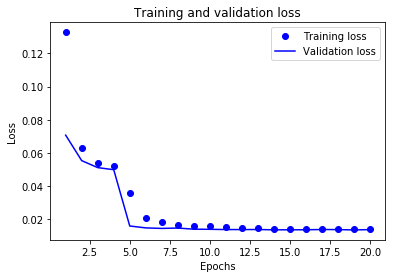

In [74]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



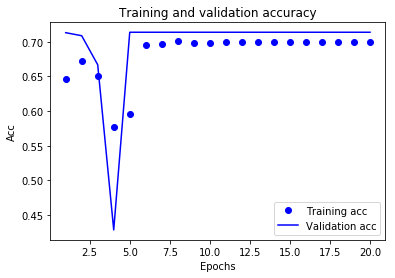

In [75]:
plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

## Print out predicted values

In [76]:
b=model.predict(X_train)